# Alphalens and Pyfolio integration

Alphalens can simulate the performance of a portfolio where the factor values are use to weight stocks. Once the portfolio is built, it can be analyzed by Pyfolio. For details on how this portfolio is built see:
- alphalens.performance.factor_returns
- alphalens.performance.cumulative_returns 
- alphalens.performance.create_pyfolio_input

In [1]:
%pylab inline --no-import-all
import alphalens
import pyfolio
import pandas as pd
import numpy as np
import datetime

Populating the interactive namespace from numpy and matplotlib


First load some stocks data

In [2]:
tickers = [ 'ACN', 'ATVI', 'ADBE', 'AMD', 'AKAM', 'ADS', 'GOOGL', 'GOOG', 'APH', 'ADI', 'ANSS', 'AAPL',
'AVGO', 'CA', 'CDNS', 'CSCO', 'CTXS', 'CTSH', 'GLW', 'CSRA', 'DXC', 'EBAY', 'EA', 'FFIV', 'FB',
'FLIR', 'IT', 'GPN', 'HRS', 'HPE', 'HPQ', 'INTC', 'IBM', 'INTU', 'JNPR', 'KLAC', 'LRCX', 'MA', 'MCHP',
'MSFT', 'MSI', 'NTAP', 'NFLX', 'NVDA', 'ORCL', 'PAYX', 'PYPL', 'QRVO', 'QCOM', 'RHT', 'CRM', 'STX',
'AMG', 'AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG', 'AIZ', 'BAC', 'BK', 'BBT', 'BRK.B', 'BLK', 'HRB',
'BHF', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CMA', 'DFS', 'ETFC', 'RE', 'FITB', 'BEN',
'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JPM', 'KEY', 'LUK', 'LNC', 'L', 'MTB', 'MMC', 'MET', 'MCO', 'MS',
'NDAQ', 'NAVI', 'NTRS', 'PBCT', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'STI', 'SYF', 'TROW',
'ABT', 'ABBV', 'AET', 'A', 'ALXN', 'ALGN', 'AGN', 'ABC', 'AMGN', 'ANTM', 'BCR', 'BAX', 'BDX', 'BIIB', 'BSX',
'BMY', 'CAH', 'CELG', 'CNC', 'CERN', 'CI', 'COO', 'DHR', 'DVA', 'XRAY', 'EW', 'EVHC', 'ESRX', 'GILD', 'HCA',
'HSIC', 'HOLX', 'HUM', 'IDXX', 'ILMN', 'INCY', 'ISRG', 'IQV', 'JNJ', 'LH', 'LLY', 'MCK', 'MDT', 'MRK', 'MTD',
'MYL', 'PDCO', 'PKI', 'PRGO', 'PFE', 'DGX', 'REGN', 'RMD', 'SYK', 'TMO', 'UNH', 'UHS', 'VAR', 'VRTX', 'WAT',
'MMM', 'AYI', 'ALK', 'ALLE', 'AAL', 'AME', 'AOS', 'ARNC', 'BA', 'CHRW', 'CAT', 'CTAS', 'CSX', 'CMI', 'DE',
'DAL', 'DOV', 'ETN', 'EMR', 'EFX', 'EXPD', 'FAST', 'FDX', 'FLS', 'FLR', 'FTV', 'FBHS', 'GD', 'GE', 'GWW',
'HON', 'INFO', 'ITW', 'IR', 'JEC', 'JBHT', 'JCI', 'KSU', 'LLL', 'LMT', 'MAS', 'NLSN', 'NSC', 'NOC', 'PCAR',
'PH', 'PNR', 'PWR', 'RTN', 'RSG', 'RHI', 'ROK', 'COL', 'ROP', 'LUV', 'SRCL', 'TXT', 'TDG', 'UNP', 'UAL',
'AES', 'LNT', 'AEE', 'AEP', 'AWK', 'CNP', 'CMS', 'ED', 'D', 'DTE', 'DUK', 'EIX', 'ETR', 'ES', 'EXC']

In [3]:
import pandas_datareader.data as web
pan = web.DataReader(tickers, "yahoo", datetime.datetime(2015, 1, 1),  datetime.datetime(2017, 1, 1))

/home/lucasca/.local/lib/python3.5/site-packages/pandas_datareader/yahoo/daily.py:136: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


In [4]:
pan = pan.transpose(2,1,0)

We'll compute a simple mean reversion factor looking at recent stocks performance: stocks that performed well in the last 5 days will have high rank and vice versa.

In [5]:
factor = pan.loc[:,:,'Open']
factor = -factor.pct_change(5)

factor = factor.stack()
factor.index = factor.index.set_names(['date', 'asset'])

The pricing data passed to alphalens should contain the entry price for the assets so it must reflect the next available price after a factor value was observed at a given timestamp. Those prices must not be used in the calculation of the factor values for that time. Always double check to ensure you are not introducing lookahead bias to your study.

The pricing data must also contain the exit price for the assets, for period 1 the price at the next timestamp will be used, for period 2 the price after 2 timestats will be used and so on.

There are no restrinctions/assumptions on the time frequencies a factor should be computed at and neither on the specific time a factor should be traded (trading at the open vs trading at the close vs intraday trading), it is only required that factor and price DataFrames are properly aligned given the rules above.

In our example, before the trading starts every day, we observe yesterday factor values. The price we pass to alphalens is the next available price after that factor observation: the daily open price that will be used as assets entry price. Also, we are not adding additional prices so the assets exit price will be the following days open prices (how many days depends on 'periods' argument). The retuns computed by Alphalens will therefore based on assets open prices.

In [6]:
pricing = pan.loc[:,:,'Open'].iloc[1:]

# Prepare data and run Alphalens

Pyfolio wants timezone set to UTC

In [7]:
pricing.index = pricing.index.tz_localize('UTC')

In [8]:
factor = factor.unstack()
factor.index = factor.index.tz_localize('UTC')
factor = factor.stack()

In [9]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor,
                                                                   pricing,
                                                                   periods=(1, 3),
                                                                   quantiles=5,
                                                                   bins=None)

Dropped 0.6% entries from factor data (0.6% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-63.109756,0.075805,-0.044878,0.408326,24353,20.142427
2,-0.113547,0.096591,-0.013833,0.020864,24135,19.962119
3,-0.080349,0.111700,-0.001698,0.019716,24009,19.857904
4,-0.046988,0.127588,0.010359,0.020195,24131,19.958810
5,-0.027719,0.846154,0.036840,0.035748,24276,20.078740


Returns Analysis


,1D,3D
Ann. alpha,0.761,0.216
beta,0.209,-0.012
Mean Period Wise Return Top Quantile (bps),5.044,2.078
Mean Period Wise Return Bottom Quantile (bps),-2.559,-1.478
Mean Period Wise Spread (bps),7.619,3.544


Information Analysis


,1D,3D
IC Mean,0.014,0.009
IC Std.,0.173,0.169
Risk-Adjusted IC,0.081,0.056
t-stat(IC),1.804,1.247
p-value(IC),0.072,0.213
IC Skew,0.029,0.183
IC Kurtosis,0.347,0.316


Turnover Analysis


,1D,3D
Quantile 1 Mean Turnover,0.346,0.602
Quantile 2 Mean Turnover,0.605,0.744
Quantile 3 Mean Turnover,0.649,0.763
Quantile 4 Mean Turnover,0.603,0.745
Quantile 5 Mean Turnover,0.349,0.596


,1D,3D
Mean Factor Rank Autocorrelation,0.753,0.361


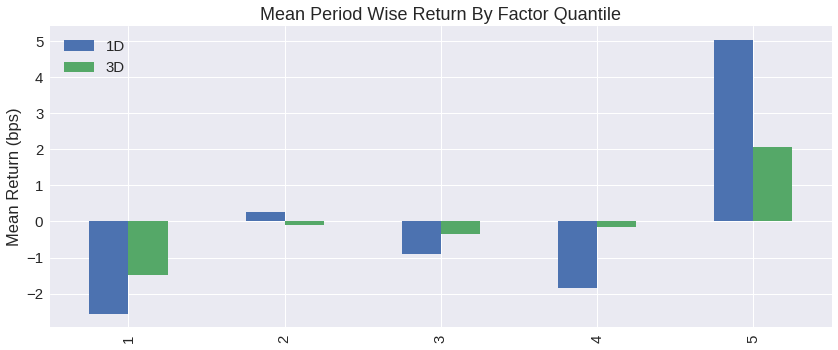

In [10]:
alphalens.tears.create_summary_tear_sheet(factor_data)

# Prepare data for Pyfolio

We can see in Alphalens analysis that quantiles 1 and 5 are the most predictive so we'll build a portfolio data using only those quantiles.

In [11]:
pf_returns, pf_benchmark = alphalens.performance.create_pyfolio_input(factor_data,
                                                                      period='3D',
                                                                      long_short=True,
                                                                      group_neutral=False,
                                                                      quantiles=[1,5],
                                                                      groups=None)

Now that we have prepare the data we can run Pyfolio functions

Start date,2015-01-09
End date,2016-12-30
Total months,34
,Backtest
Annual return,31.9%
Cumulative returns,121.1%
Annual volatility,16.7%
Sharpe ratio,1.74
Calmar ratio,1.82
Stability,0.59
Max drawdown,-17.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.56,2015-03-09,2015-03-19,2015-06-03,63
1,8.19,2016-03-29,2016-10-07,NaT,NaN
2,5.90,2015-02-10,2015-03-06,2015-03-08,19
3,4.25,2016-01-04,2016-02-08,2016-02-26,40
4,2.13,2015-08-29,2015-09-29,2015-10-12,31


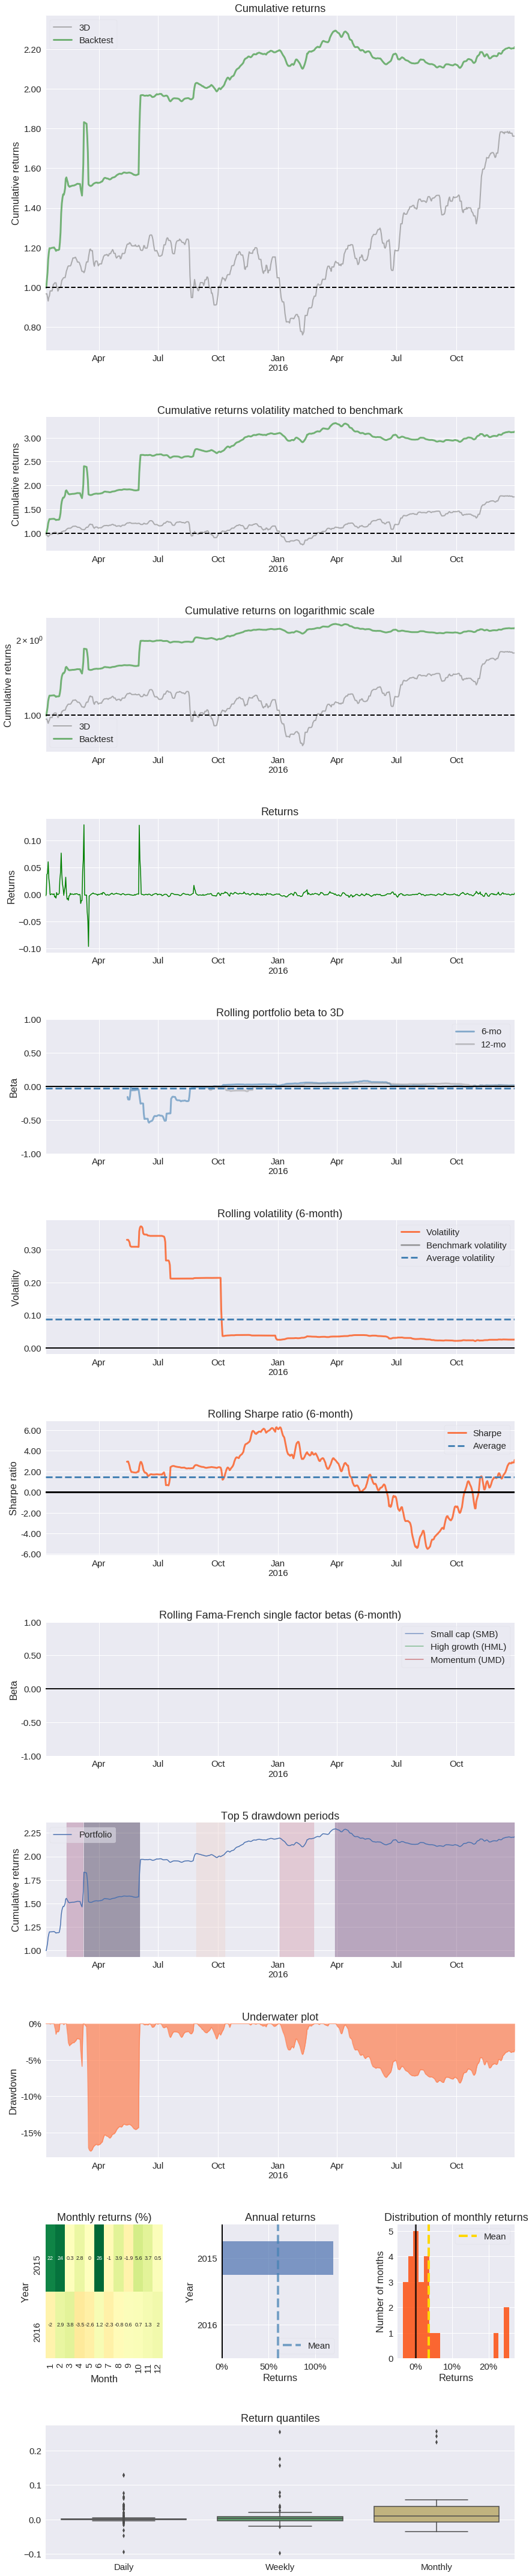

/home/lucasca/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Stress Events,mean,min,max
Fall2015,0.04%,-0.31%,1.70%
New Normal,0.12%,-9.60%,12.89%


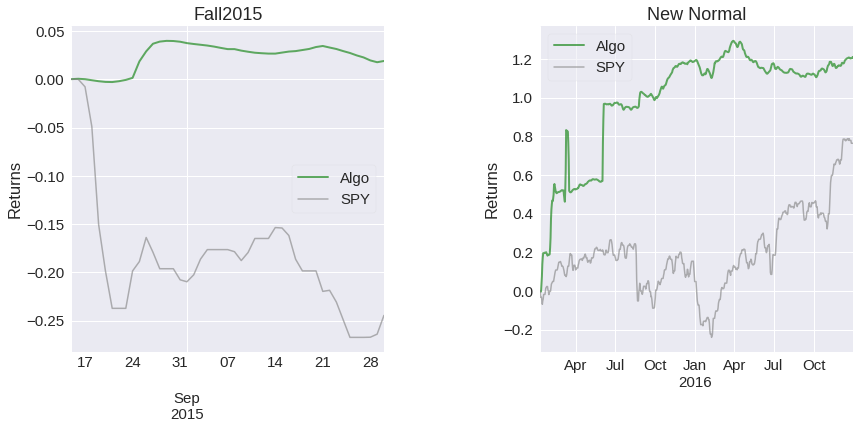

In [12]:
pyfolio.tears.create_full_tear_sheet(pf_returns, benchmark_rets=pf_benchmark)